# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [9]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data 
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    
    mask = range(num_test, num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # Shape of the data that comes in
    print('\n\nShape of raw data from dataset:')
    print('Training set\n{}\n\nLabel set:\n{}\n'
          .format(X_test.shape, y_test.shape))
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # current shape
    print('Reshaped data to M x N (examples x features):')
    print('Train data shape: ', X_train.shape)
    print('Train labels shape: ', y_train.shape)
    print('Validation data shape: ', X_val.shape)
    print('Validation labels shape: ', y_val.shape)
    print('Test data shape: ', X_test.shape)
    print('Test labels shape: ', y_test.shape)

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

print('\n\nShape after adding bias dimension and transforming into columns:')
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)




Shape of raw data from dataset:
Training set
(1000, 32, 32, 3)

Label set:
(1000,)

Reshaped data to M x N (examples x features):
Train data shape:  (48000, 3072)
Train labels shape:  (48000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


Shape after adding bias dimension and transforming into columns:
Train data shape:  (3073, 48000)
Train labels shape:  (48000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 1000)
Test labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [11]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(10, 3073) * 0.0001
print('Weight Matrix shape: {}\n'.format(W.shape))
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: {}'.format(loss))
print('sanity check: {}'.format(-np.log(0.1)))

Weight Matrix shape: (10, 3073)

loss: 2.3754593931741637
sanity check: 2.3025850929940455


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.019166698428385587 analytic: -0.014545831731222352, relative error: 0.13706674270030442
numerical: -3.2899021418675285 analytic: -3.835120761498654, relative error: 0.07652166554770509
numerical: -0.921849289925447 analytic: -0.6323791803634247, relative error: 0.18624681962505868
numerical: 0.368799114558449 analytic: 0.1476340328062346, relative error: 0.4282550081860582
numerical: -1.2150419530509993 analytic: -1.0422808776698673, relative error: 0.07653361452334287
numerical: -0.920908368717832 analytic: -0.6445193287989854, relative error: 0.17655816385341383
numerical: 0.7587133501019138 analytic: -0.054521306887924226, relative error: 1.0
numerical: 2.1181559898053592 analytic: 1.602808607317001, relative error: 0.1384983299456562
numerical: -1.699020146417318 analytic: -1.1917029673402793, relative error: 0.17549836463499494
numerical: -0.41247556936685464 analytic: -0.11448713703041859, relative error: 0.5654829624921973


In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print('naive loss: {} computed in {}'.format(loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print('vectorized loss: {} computed in {}'.format(loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: {}'.format(np.abs(loss_naive - loss_vectorized)))
print('Gradient difference: {}'.format(grad_difference))

naive loss: 2.3130958747428467 computed in 7.24904465675354
vectorized loss: 2.313095874742853 computed in 0.49280834197998047
Loss difference: 6.217248937900877e-15
Gradient difference: 151.03533510280894


### Process Dataset into Validation subsets
In order to tune the hyper parameters, I am going to split the dataset into a number of subsets. Each subset would be the validation data, and the remaining data would make up the training set to be used with the validation data. For example, if I made 10 subsets of data, I would have 10 validation sets of 1/10 of the training data, and a unique training set with the other 9/10 of the data, for each set of validation data.

In [28]:
def create_dataset_folds(train_set, label_set, num_folds=5, ex_axis=1):
    '''
    data processing script, takes a 2D dataset and creates a 3D dataset 
    containing permutations of the 2D dataset, with each of the
    'num_folds' permutation containing a unique validation set.
    
    input:
        num_folds: number of permutations/validation sets to be made
        train_set: bulk dataset, 2D, dimensions(D) x examples(N)
        label_set: bulk dataset, 1D, (N) labels/classes/output values
        ex_axis: handles datasets where examples are in rows(0) or columns(1)
        
    output:
        train_sets: post processed dataset, permutations(n) x D x (N - n/N)
        label_sets: post processed dataset, n x N
        valid_sets: post processed validation dataset, n x D x N/n
    '''
    
    print('\nCreating Permutations of Training set for validation testing..\n')
    print('Current Dataset shape:')
    print(
          '\ttraining sets:\t\t{} (Dimensions x Examples)'
          '\n\ttraining lbls:\t\t{} (labels)'.format(
                                train_set.shape,
                                label_set.shape))
    
    # Make sure the dataset can be split evenly
    if train_set.shape[ex_axis] % num_folds != 0:
        raise ValueError('Data set not divisible by number of folds. '
                         'Choose different fold size')
    
    print('\nSplitting up training set into n folds...\n')
    # Split up the data -- num_folds x dimensions x subset of examples
    train_folds = np.array(np.split(train_set, num_folds, axis=ex_axis))
    label_folds = np.array(np.split(label_set, num_folds), dtype=np.int)
    
    # Output array shape parameters
    sample_size = int(train_set.shape[ex_axis] * (1 - 1 / num_folds))
    number_dims = train_set.shape[1 - ex_axis]
    validations = train_set.shape[ex_axis] // num_folds
    
    print('\nCreating empty 3D result arrays\n')
    ##############
    # MEMORY HOG:#
    ##############
    # Assuming the dimensions are rows, create the output arrays
    if ex_axis == 1:
        train_sets = np.zeros(shape=(num_folds, number_dims, sample_size))
        train_lbls = np.zeros(shape=(num_folds, sample_size), dtype=np.int)
        valid_sets = np.zeros(shape=(num_folds, number_dims, validations))
        valid_lbls = np.zeros(shape=(num_folds, validations), dtype=np.int)
    # Assuming the dimensions are columns, create output arrays
    else:
        train_sets = np.zeros(shape=(num_folds, sample_size, number_dims))
        train_lbls = np.zeros(shape=(num_folds, sample_size), dtype=np.int)
        valid_sets = np.zeros(shape=(num_folds, validations, number_dims))
        valid_lbls = np.zeros(shape=(num_folds, validations), dtype=np.int)
        
    Print('/nReshaping arrays into the 3D results arrays...\n')
    # Start massaging split data into the 3D output arrays
    for fold in range(num_folds):
        
        # create the validation set
        valid_sets[fold] = train_folds[fold]
        valid_lbls[fold] = label_folds[fold]
        
        # remove validation set, add remainder to the 3D output array
        if ex_axis == 1:               
            train_sets[fold] = np.delete(train_folds, fold, axis=0).reshape(number_dims, -1)
            train_lbls[fold] = np.delete(label_folds, fold, axis=0).reshape((-1,))
        # handles datasets where examples are in rows, not columns
        else:
            train_sets[fold] = np.delete(train_folds, fold, axis=0).reshape(-1, number_dims)
            train_lbls[fold] = np.delete(label_folds, fold, axis=0).reshape((-1,))
            
    print('\nNew set shapes:')
    print('\tvalidation sets:\t{}'
          '\n\tvalidation lbls:\t{}'
          '\n\ttraining sets:\t\t{}'
          '\n\ttraining lbls:\t\t{}'.format(
                                valid_sets.shape,
                                valid_lbls.shape,
                                train_sets.shape,
                                train_lbls.shape))
    
    return train_sets, train_lbls, valid_sets, valid_lbls
            


Creating Permutations of Training set for validation testing..

Current Dataset shape:
	training sets:		(3073, 48000) (Dimensions x Examples)
	training lbls:		(48000,) (labels)

New set shapes:
	validation sets:	(5, 3073, 9600)
	validation lbls:	(5, 9600)
	training sets:		(5, 3073, 38400)
	training lbls:		(5, 38400)


In [ ]:
# Process the dataset into folds
X_train_folds, y_train_folds, X_valid_folds, y_valid_folds = create_dataset_folds(X_train, y_train, num_folds=5, ex_axis=1)

In [16]:
from mpl_toolkits.mplot3d import axes3d


In [53]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 5e-8]
regularization_strengths = [5e2, 1e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# 
num_folds = range(5)
# Plotting axes
r, l, a = [], [], []
loss_hist = [[] for _ in num_folds]
for lr in learning_rates:
    for rg in regularization_strengths:
        for i in num_folds:
            
            # train the training subset
            softMax_Classifier = Softmax()
            loss_hist[i] = softMax_Classifier.train(X_train_folds[i], 
                                                 y_train_folds[i], 
                                                 learning_rate=lr, 
                                                 reg=rg)

            # generate predicted labels with classifier
            train_predictions = softMax_Classifier.predict(X_train_folds[i])
            valid_predictions = softMax_Classifier.predict(X_valid_folds[i])
            
            # compare to actual labels
            tr_accuracy = np.mean(y_train_folds[i] == train_predictions)
            vd_accuracy = np.mean(y_valid_folds[i] == valid_predictions)
            
            # hold on to highest accuracy and softmax classifier
            if vd_accuracy > best_val: 
                best_val = vd_accuracy
                
                best_tr_accuracy = tr_accuracy
                best_vd_accuracy = vd_accuracy
                best_softmax = softMax_Classifier
                
            # Add to plot matrix
            r.append(rg)
            l.append(lr)
            a.append(vd_accuracy)
            
        # Store in results dictionary
        results[(rg, lr)] = (best_tr_accuracy, best_vd_accuracy)
    

iteration 0 / 100: loss 779.2418623641305
iteration 0 / 100: loss 777.4615770840793
iteration 0 / 100: loss 770.9595721674516
iteration 0 / 100: loss 771.6286654087197
iteration 0 / 100: loss 777.3438610150572
iteration 0 / 100: loss 1526117.8616041136


C:\Users\joshu\documents\cs231n\assignment1\cs231n\classifiers\softmax.py:89: RuntimeWarning: divide by zero encountered in log
  prob_y = prob[y, np.arange(N)]


iteration 0 / 100: loss 1504619.7559989328
iteration 0 / 100: loss 1547787.2823418651
iteration 0 / 100: loss 1556402.8970339913
iteration 0 / 100: loss 1530846.5710082513
iteration 0 / 100: loss 778.7859606904502
iteration 0 / 100: loss 767.2707508735087
iteration 0 / 100: loss 762.5408362443468
iteration 0 / 100: loss 776.8598519485906
iteration 0 / 100: loss 775.2078798930022
iteration 0 / 100: loss 1554338.9160067483


C:\Users\joshu\documents\cs231n\assignment1\cs231n\classifiers\softmax.py:89: RuntimeWarning: overflow encountered in double_scalars
  prob_y = prob[y, np.arange(N)]
C:\Users\joshu\documents\cs231n\assignment1\cs231n\classifiers\softmax.py:89: RuntimeWarning: overflow encountered in square
  prob_y = prob[y, np.arange(N)]


iteration 0 / 100: loss 1552782.258255232
iteration 0 / 100: loss 1559685.592376543
iteration 0 / 100: loss 1530442.906512337
iteration 0 / 100: loss 1522979.9206569074
iteration 0 / 100: loss 774.6169753125954
iteration 0 / 100: loss 774.8907138395568
iteration 0 / 100: loss 775.8739619330139
iteration 0 / 100: loss 777.3872927845043
iteration 0 / 100: loss 762.8412297628663
iteration 0 / 100: loss 1534611.5940443715
iteration 0 / 100: loss 1541899.9460851408
iteration 0 / 100: loss 1536159.4471683602
iteration 0 / 100: loss 1547501.5708774033
iteration 0 / 100: loss 1536263.32987481


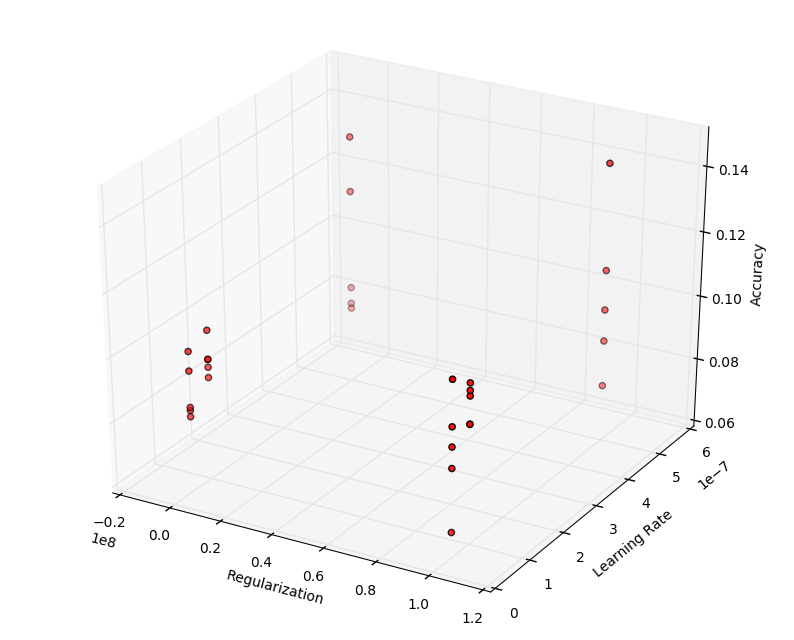

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(r, l, a, c='r', marker='o')
ax.set_xlabel('Regularization')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Accuracy')

plt.show()

In [55]:

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    
    print('lr {}\treg {} train accuracy: {} val accuracy: {:05.2f}'
          .format(lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: {:05.2f}'.format(best_val))

lr 50000.0	reg 5e-08 train accuracy: 0.10229166666666667 val accuracy: 00.14
lr 50000.0	reg 1e-07 train accuracy: 0.10049479166666667 val accuracy: 00.10
lr 50000.0	reg 5e-07 train accuracy: 0.111640625 val accuracy: 00.14
lr 100000000.0	reg 5e-08 train accuracy: 0.10229166666666667 val accuracy: 00.14
lr 100000000.0	reg 1e-07 train accuracy: 0.10221354166666667 val accuracy: 00.11
lr 100000000.0	reg 5e-07 train accuracy: 0.10229166666666667 val accuracy: 00.14
best validation accuracy achieved during cross-validation: 00.14


In [12]:
# evaluate on test set
# Evaluate the best svm on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: {}'.format(test_accuracy, ))

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])